📦 Setup & Libraries

In [1]:
# === Portfolio Optimization with Sector-Based Equal Investment ===
# This notebook performs portfolio optimization based on Modern Portfolio Theory (Markowitz),
# ensuring equal sector representation. It integrates:
# - Expected return & volatility analysis
# - Risk-adjusted performance metrics (Sharpe, Sortino, Calmar)
# - Risk decomposition (Expected Shortfall, Herfindahl index, Entropy)
# - Out-of-sample validation with train/test split
# - Capital Market Line visualization using a real 'NoRisk' asset with constant price

# --- Import essential Python libraries ---
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

# For consistent results in randomized operations
np.random.seed(42)

# Matplotlib default style
plt.style.use("ggplot")

 ⚠️ Run this block only once to generate the 'NoRisk.csv' file

In [32]:
# Create a real 'NoRisk' stock (constant price) to simulate a risk-free asset
template_df = pd.read_csv("stocks/AVGO.csv")

# Normalize column names
template_df.columns = [col.strip().lower().replace('/', '_').replace(' ', '_') for col in template_df.columns]

# Parse and sort dates
template_df['date'] = pd.to_datetime(template_df['date'])
template_df = template_df.sort_values('date')

# Create constant-price NoRisk DataFrame
no_risk = pd.DataFrame({
    'date': template_df['date'],
    'open': 1.0,
    'high': 1.0,
    'low': 1.0,
    'close': 1.0,
    'volume': 0
})

# Save to CSV
no_risk.to_csv("stocks/NoRisk.csv", index=False)
print("✅ NoRisk.csv created")


✅ NoRisk.csv created


📄 Load Company & Sector Information

In [2]:
# === STEP 1: Load and clean company-sector mapping ===
# This step loads the list of selected companies and maps each ticker to its respective sector.
# The 'NoRisk' asset represents a constant-price instrument (e.g., money market fund)
# and is treated as an additional sector to include it in the optimization.

# Load CSV containing ticker-symbols and sectors
df_companies = pd.read_csv("selected_company_sample.csv")

# Ensure consistent column naming
df_companies.rename(columns={'Symbol': 'Ticker'}, inplace=True)

# Add synthetic NoRisk asset to company list
df_companies = pd.concat([
    df_companies,
    pd.DataFrame([{'Ticker': 'NoRisk', 'Sector': 'Synthetic'}])
], ignore_index=True)

# Extract unique sectors from the dataset
sectors = df_companies['Sector'].unique()

# Display the number of sectors and a preview of the mapping
print(f"Total sectors: {len(sectors)}")
print("Sample of sector-ticker mapping:")
print(df_companies.head())

Total sectors: 4
Sample of sector-ticker mapping:
   Unnamed: 0 Ticker                    Name                  Sector
0       106.0    CMG  Chipotle Mexican Grill  Consumer Discretionary
1       313.0    MHK       Mohawk Industries  Consumer Discretionary
2       206.0   GRMN             Garmin Ltd.  Consumer Discretionary
3       279.0    LEG         Leggett & Platt  Consumer Discretionary
4       345.0   ORLY     O'Reilly Automotive  Consumer Discretionary


🧼 Clean Individual Stock Data

In [3]:
# === STEP 2: Define helper function to clean stock data ===
# This function standardizes stock price CSVs:
# - Renames columns
# - Parses dates
# - Converts 'close' prices to float
# - Sets the date as index
# It assumes files are structured with columns like: Date, Close/Last, Volume, etc.

def clean_stock_data(filepath):
    # Read CSV
    df = pd.read_csv(filepath)

    # Standardize column names (lowercase, underscores)
    df.columns = [col.strip().lower().replace('/', '_').replace(' ', '_') for col in df.columns]

    # Rename 'close_last' to 'close' if needed
    if 'close_last' in df.columns:
        df.rename(columns={'close_last': 'close'}, inplace=True)

    # Convert price strings to float
    df['close'] = df['close'].replace('[\$,]', '', regex=True).astype(float)

    # Parse and set date index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Return only closing price
    return df[['close']]


🗂️ Load All Sector Data from CSV Files

In [4]:
# === STEP 3: Load data by sector ===
# For each sector, this function loads all stock price series into a DataFrame.
# Each sector is stored in a dictionary: { sector_name: DataFrame of tickers }

def load_sector_data(tickers, folder='stocks'):
    data = pd.DataFrame()
    for ticker in tickers:
        filepath = os.path.join(folder, f"{ticker}.csv")
        try:
            stock_data = clean_stock_data(filepath)
            data[ticker] = stock_data['close']
        except Exception as e:
            print(f"Error loading {ticker}: {e}")
    return data

# Load data for all sectors and store in a dictionary
sector_data = {}
for sector in sectors:
    tickers = df_companies[df_companies['Sector'] == sector]['Ticker'].tolist()
    sector_data[sector] = load_sector_data(tickers)

# Show example of one sector's data
example_sector = list(sector_data.keys())[0]
print(f"\nSample data for sector: {example_sector}")
print(sector_data[example_sector].head())



Sample data for sector: Consumer Discretionary
              CMG     MHK    GRMN   LEG     ORLY
date                                            
2025-06-13  50.24  101.43  201.32  9.24  89.9100
2025-06-12  50.89  104.77  208.39  9.62  91.0500
2025-06-11  51.79  104.71  209.13  9.58  90.0100
2025-06-10  50.62  105.94  210.12  9.62  91.7100
2025-06-09  51.13  103.10  208.29  9.25  89.8734


📈 Compute Daily Returns per Sector

In [5]:
# === STEP 4: Compute daily returns ===
# We compute the daily percentage returns for each stock in each sector.

# This will create a dictionary { sector_name: DataFrame of daily returns }
sector_returns = {
    sector: data.pct_change().dropna()
    for sector, data in sector_data.items()
}

# Print a preview of returns for one sector
example_sector = list(sector_returns.keys())[0]
print(f"\nSample daily returns for sector: {example_sector}")
print(sector_returns[example_sector].head())


Sample daily returns for sector: Consumer Discretionary
                 CMG       MHK      GRMN       LEG      ORLY
date                                                        
2025-06-12  0.012938  0.032929  0.035118  0.041126  0.012679
2025-06-11  0.017685 -0.000573  0.003551 -0.004158 -0.011422
2025-06-10 -0.022591  0.011747  0.004734  0.004175  0.018887
2025-06-09  0.010075 -0.026808 -0.008709 -0.038462 -0.020026
2025-06-06  0.026794 -0.015325 -0.004033 -0.016216  0.021971


C:\Users\longo\AppData\Local\Temp\ipykernel_32172\530951142.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sector: data.pct_change().dropna()


🧮 Intra-Sector Optimization & Combine Portfolios

In [6]:
# === STEP 5: Optimize portfolio within each sector ===
# We apply minimum variance optimization using Ledoit-Wolf shrinkage estimator.

def get_optimal_weights(returns):
    n = returns.shape[1]

    # Ledoit-Wolf shrinkage covariance estimator (more robust with small samples)
    lw = LedoitWolf().fit(returns)
    cov = lw.covariance_ * 252  # annualized covariance

    # Objective function: portfolio volatility
    def portfolio_volatility(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    # Constraints and bounds
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    initial_guess = np.array(n * [1. / n])

    result = minimize(portfolio_volatility, initial_guess, method='SLSQP',
                      bounds=bounds, constraints=constraints)
    return result.x

# === STEP 6: Combine sector portfolios equally ===
# Each sector contributes equally to the final portfolio.

all_tickers = []
all_weights = []

for sector in sectors:
    returns = sector_returns[sector]
    tickers = returns.columns
    weights = get_optimal_weights(returns)
    scaled_weights = weights * (1 / len(sectors))  # equal sector allocation

    all_tickers.extend(tickers)
    all_weights.extend(scaled_weights)

# Construct final portfolio
final_portfolio = pd.DataFrame({
    'Ticker': all_tickers,
    'Weight': all_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

final_portfolio_with_norisk = final_portfolio.copy()

# Display result
print("Final Portfolio Allocation (Equal Sector Allocation):")
print(final_portfolio)


Final Portfolio Allocation (Equal Sector Allocation):
    Ticker        Weight
0   NoRisk  2.500000e-01
1       CB  1.005295e-01
2     ORLY  9.467176e-02
3      IBM  9.321222e-02
4     GRMN  8.489468e-02
5       EA  6.519476e-02
6      AXP  5.360300e-02
7     EBAY  4.722305e-02
8       MS  4.563379e-02
9      BAC  4.552913e-02
10     CMG  4.527778e-02
11      IT  4.436997e-02
12     LEG  2.056986e-02
13      XL  4.704607e-03
14     MHK  4.585931e-03
15    AVGO  1.694066e-19


In [7]:
# Re-calculate the portfolio without NoRisk
df_companies_wo_norisk = df_companies[df_companies['Ticker'] != 'NoRisk']
sectors_wo_norisk = df_companies_wo_norisk['Sector'].unique()

# Re-run optimization excluding NoRisk
all_tickers_wo = []
all_weights_wo = []

for sector in sectors_wo_norisk:
    returns = sector_returns[sector]
    tickers = returns.columns
    weights = get_optimal_weights(returns)
    scaled_weights = weights * (1 / len(sectors_wo_norisk))  # Equal weight without NoRisk
    all_tickers_wo.extend(tickers)
    all_weights_wo.extend(scaled_weights)

# Build final portfolio without NoRisk
final_portfolio_without_norisk = pd.DataFrame({
    'Ticker': all_tickers_wo,
    'Weight': all_weights_wo
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Display result
print("Final Portfolio Allocation without NoRisk (Equal Sector Allocation):")
print(final_portfolio_without_norisk)


Final Portfolio Allocation without NoRisk (Equal Sector Allocation):
   Ticker        Weight
0      CB  1.340393e-01
1    ORLY  1.262290e-01
2     IBM  1.242830e-01
3    GRMN  1.131929e-01
4      EA  8.692634e-02
5     AXP  7.147067e-02
6    EBAY  6.296407e-02
7      MS  6.084505e-02
8     BAC  6.070550e-02
9     CMG  6.037037e-02
10     IT  5.915997e-02
11    LEG  2.742648e-02
12     XL  6.272809e-03
13    MHK  6.114575e-03
14   AVGO  2.258755e-19


🥧 Plot Portfolio Allocation Pie Chart

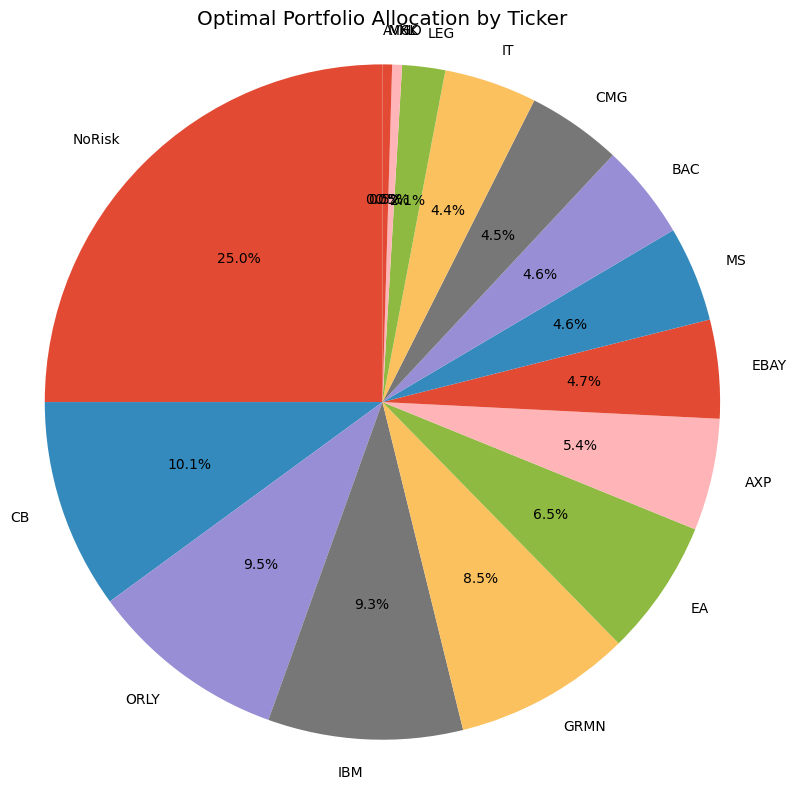

In [8]:
# === Optional: Plot pie chart ===
# Visualize the final portfolio allocation using a pie chart.

plt.figure(figsize=(8, 8))
plt.pie(
    final_portfolio['Weight'],
    labels=final_portfolio['Ticker'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Optimal Portfolio Allocation by Ticker')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.tight_layout()
plt.show()

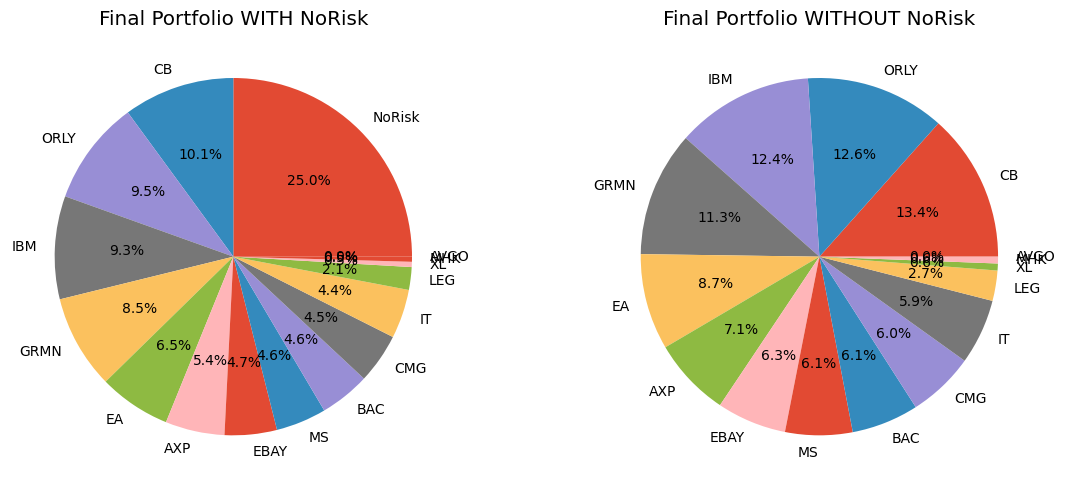

In [ ]:
# === STEP 7: Visualize Portfolio Allocation ===
# This section displays the allocation using pie charts with and without NoRisk asset

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(final_portfolio_with_norisk['Weight'],
        labels=final_portfolio_with_norisk['Ticker'],
        autopct='%1.1f%%')
plt.title('Final Portfolio WITH NoRisk')

plt.subplot(1, 2, 2)
plt.pie(final_portfolio_without_norisk['Weight'],
        labels=final_portfolio_without_norisk['Ticker'],
        autopct='%1.1f%%')
plt.title('Final Portfolio WITHOUT NoRisk')

plt.tight_layout()
plt.show()

🧪 Split Data

In [10]:
# === STEP 8: Combine all sector returns and add synthetic risk-free asset ===
# We create a unified returns DataFrame, including the real 'NoRisk' asset
# with constant daily returns based on constant prices.
# The data is then split into training, validation, and test sets.

# Merge all sector returns into a single DataFrame (including NoRisk)
returns_df = pd.concat(sector_returns.values(), axis=1).dropna()

# Sort chronologically
returns_df = returns_df.sort_index()

# Determine date boundaries for train/val/test split
end_date = returns_df.index.max()
test_start = end_date - pd.DateOffset(months=6)
val_start = end_date - pd.DateOffset(months=12)

# Perform split
returns_train = returns_df[returns_df.index < val_start]
returns_val = returns_df[(returns_df.index >= val_start) & (returns_df.index < test_start)]
returns_test = returns_df[returns_df.index >= test_start]
returns_modeling = pd.concat([returns_train, returns_val]).sort_index()

# --- Sanity checks ---
if len(returns_train) == 0 or len(returns_test) == 0:
    raise ValueError("Dataset too short: ensure at least 12 months of data.")

# Summary output
print("Train set:     ", returns_train.index.min().date(), "→", returns_train.index.max().date(), f"({len(returns_train)} rows)")
print("Validation set:", returns_val.index.min().date(), "→", returns_val.index.max().date(), f"({len(returns_val)} rows)")
print("Test set:      ", returns_test.index.min().date(), "→", returns_test.index.max().date(), f"({len(returns_test)} rows)")

Train set:      2015-06-17 → 2024-06-11 (2262 rows)
Validation set: 2024-06-12 → 2024-12-11 (127 rows)
Test set:       2024-12-12 → 2025-06-12 (124 rows)


📊 Efficient Frontier & Max Sharpe Portfolio (Tangency Portfolio)

In [11]:
# === STEP 9: Compute Efficient Frontier and Tangency Portfolio ===
# This section computes:
# - the maximum Sharpe ratio portfolio (tangency)
# - the efficient frontier of mean-variance portfolios

# Extract symbols and compute statistics
symbols = returns_df.columns
mean_returns = returns_modeling.mean()
lw = LedoitWolf().fit(returns_modeling)
cov_matrix = lw.covariance_
n_assets = len(symbols)

# === Set Risk-Free Rate ===
# In this model, the 'NoRisk' asset has a constant price of 1.0 → zero daily returns.
# Therefore, the implied risk-free rate is 0%.
rf = 0.0

# --- Max Sharpe Ratio Portfolio (Tangency Portfolio) ---
def negative_sharpe(weights, mu, cov, rf=0.0):
    port_return = np.dot(weights, mu)
    port_vol = np.sqrt(weights.T @ cov @ weights)
    return - (port_return - rf) / port_vol

bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
initial_guess = np.repeat(1 / n_assets, n_assets)

result = minimize(negative_sharpe, initial_guess,
                  args=(mean_returns, cov_matrix, rf),
                  method='SLSQP', bounds=bounds, constraints=constraints)

tangent_weights = result.x
tangent_return = np.dot(tangent_weights, mean_returns) * 252
tangent_vol = np.sqrt(tangent_weights.T @ cov_matrix @ tangent_weights) * np.sqrt(252)
tangent_sharpe = (tangent_return - rf) / tangent_vol

# --- Efficient Frontier ---
efficient_returns = []
efficient_risks = []
efficient_weights = []

target_returns = np.linspace(0.0001, 0.003, 100)  # Daily returns

for target_return in target_returns:
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}
    ]

    result = minimize(portfolio_volatility, initial_guess,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        efficient_returns.append(target_return)
        efficient_risks.append(result.fun)
        efficient_weights.append(result.x)

# Convert to annualized metrics
annual_returns = [r * 252 for r in efficient_returns]
annual_vols = [v * np.sqrt(252) for v in efficient_risks]

# Sharpe ratios for frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(efficient_returns, efficient_risks)]
max_sharpe_idx = np.argmax(sharpe_ratios)
min_var_idx = np.argmin(efficient_risks)

# Store optimal weights
max_sharpe_weights = efficient_weights[max_sharpe_idx]
min_var_weights = efficient_weights[min_var_idx]

# Output info
print(f"Max Sharpe Portfolio Return:    {annual_returns[max_sharpe_idx]:.4f}")
print(f"Max Sharpe Portfolio Volatility:{annual_vols[max_sharpe_idx]:.4f}")
print(f"Max Sharpe Ratio:               {sharpe_ratios[max_sharpe_idx]:.4f}")

Max Sharpe Portfolio Return:    0.5493
Max Sharpe Portfolio Volatility:0.5320
Max Sharpe Ratio:               0.0650


📉 Plot Efficient Frontier and Capital Market Line (CML)

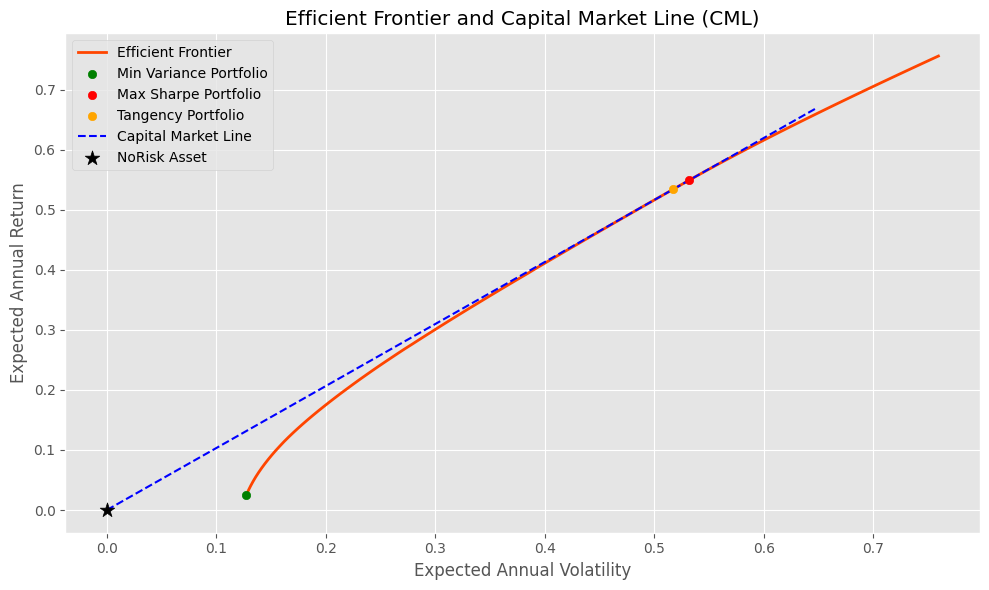

In [12]:
# === STEP 10: Plot Efficient Frontier and Capital Market Line (CML) ===
# This plot shows:
# - the efficient frontier
# - the Capital Market Line (CML)
# - the minimum variance and max Sharpe portfolios
# - the actual NoRisk asset (constant-price instrument)

plt.figure(figsize=(10, 6))

# Efficient Frontier
plt.plot(annual_vols, annual_returns, label='Efficient Frontier', linewidth=2, color='orangered')

# Key Portfolios
plt.scatter(annual_vols[min_var_idx], annual_returns[min_var_idx],
            color='green', label='Min Variance Portfolio', zorder=5)
plt.scatter(annual_vols[max_sharpe_idx], annual_returns[max_sharpe_idx],
            color='red', label='Max Sharpe Portfolio', zorder=5)
plt.scatter(tangent_vol, tangent_return,
            color='orange', label='Tangency Portfolio', zorder=5)

# === Recompute tangent_sharpe properly ===
tangent_sharpe = (tangent_return - rf) / tangent_vol

# Capital Market Line: line from (0, rf) to (tangent_vol, tangent_return)
cml_volatility = np.linspace(0, tangent_vol * 1.25, 100)
cml_return = rf + tangent_sharpe * cml_volatility
plt.plot(cml_volatility, cml_return, linestyle='--', color='blue', label='Capital Market Line')

# Risk-Free Asset
rf_point = returns_df["NoRisk"].mean() * 252
plt.scatter(0, rf_point, color='black', marker='*', s=120, label='NoRisk Asset', zorder=5)

# Labels and legend
plt.xlabel('Expected Annual Volatility')
plt.ylabel('Expected Annual Return')
plt.title('Efficient Frontier and Capital Market Line (CML)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

💾 Portfolio Weights and Export to CSV

In [13]:
# === STEP 11: Show and Export Optimal Portfolio Weights ===
# Display the asset allocations for the Min Variance and Max Sharpe portfolios
# and save them to CSV files.

# Display Minimum Variance Portfolio Weights
print("\n--- Minimum Variance Portfolio Weights ---")
for sym, w in zip(symbols, min_var_weights):
    if w > 0.001:
        print(f"{sym}: {w:.4f}")

# Display Maximum Sharpe Ratio Portfolio Weights
print("\n--- Maximum Sharpe Ratio Portfolio Weights ---")
for sym, w in zip(symbols, max_sharpe_weights):
    if w > 0.001:
        print(f"{sym}: {w:.4f}")

# Create and export DataFrames
min_var_portfolio = pd.DataFrame({
    'Ticker': symbols,
    'Weight': min_var_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

max_sharpe_portfolio = pd.DataFrame({
    'Ticker': symbols,
    'Weight': max_sharpe_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Save to CSV
final_portfolio.to_csv("final_portfolio.csv", index=False)
final_portfolio_without_norisk.to_csv("final_portfolio_without_norisk.csv", index=False)
min_var_portfolio.to_csv("min_variance_portfolio.csv", index=False)
max_sharpe_portfolio.to_csv("max_sharpe_portfolio.csv", index=False)

print("\nPortfolio weights saved to CSV files:")
print("- final_portfolio.csv (Equal Sector Allocation)")
print("- final_portfolio_without_norisk.csv (Equal Sector Allocation, No NoRisk)")
print("- min_variance_portfolio.csv (Minimum Variance Portfolio)")
print("- max_sharpe_portfolio.csv (Maximum Sharpe Ratio Portfolio)")



--- Minimum Variance Portfolio Weights ---
CMG: 0.0278
MHK: 0.0077
GRMN: 0.0196
LEG: 0.0740
ORLY: 0.0225
XL: 0.0197
CB: 0.0578
IBM: 0.0940
EBAY: 0.0451
EA: 0.0794
NoRisk: 0.5525

--- Maximum Sharpe Ratio Portfolio Weights ---
LEG: 0.7371
XL: 0.2629

Portfolio weights saved to CSV files:
- final_portfolio.csv (Equal Sector Allocation)
- final_portfolio_without_norisk.csv (Equal Sector Allocation, No NoRisk)
- min_variance_portfolio.csv (Minimum Variance Portfolio)
- max_sharpe_portfolio.csv (Maximum Sharpe Ratio Portfolio)


⚠️ Define Risk and Performance Metrics

In [14]:
# === Additional Utilities: Risk and Performance Metrics ===

def expected_shortfall(returns, alpha=0.05):
    """
    Expected Shortfall (CVaR): average loss in the worst alpha% of cases.
    """
    sorted_returns = np.sort(returns)
    cutoff_index = int(np.ceil(alpha * len(sorted_returns)))
    return -np.mean(sorted_returns[:cutoff_index])

def sortino_ratio(returns, target=0):
    """
    Sortino Ratio: uses downside deviation instead of total volatility.
    """
    downside = returns[returns < target]
    downside_std = np.std(downside) if len(downside) > 0 else 1e-6
    return (returns.mean() - target) / downside_std

def calmar_ratio(returns):
    """
    Calmar Ratio: annual return divided by the absolute value of the maximum drawdown.
    """
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    annual_return = returns.mean() * 252
    return annual_return / abs(max_drawdown) if max_drawdown < 0 else np.nan

📅 Out-of-Sample Performance Evaluation


=== Out-of-Sample Performance (Last 6 Months) ===

Max Sharpe Portfolio:
  Return:     0.8285
  Volatility: 0.5360
  Sharpe:     1.5458
  Sortino:    0.1273
  Calmar:     3.6845
  CVaR 5%:    0.0721

Min Variance Portfolio:
  Return:     0.0707
  Volatility: 0.1016
  Sharpe:     0.6955
  Sortino:    0.0630
  Calmar:     1.0406
  CVaR 5%:    0.0139


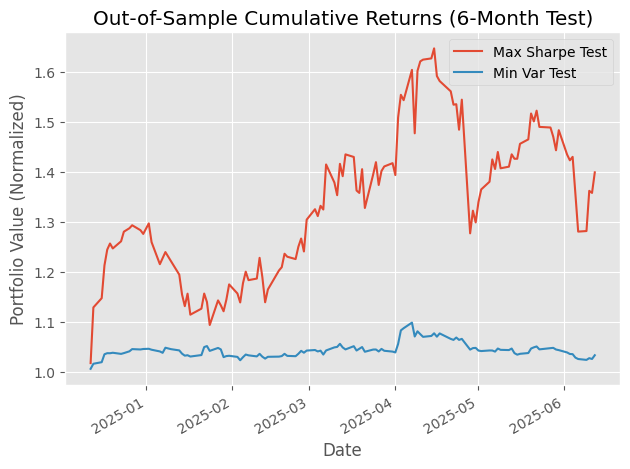

In [15]:
# === STEP 12: Evaluate Out-of-Sample Performance (Test Set) ===
# We apply the optimal portfolios to unseen test data (last 6 months)
# and compute risk-adjusted performance metrics.

# Helper: compute portfolio returns
def compute_portfolio_returns(weights, returns_df):
    return returns_df @ weights

# Portfolio returns on test set
max_sharpe_test = compute_portfolio_returns(max_sharpe_weights, returns_test)
min_var_test = compute_portfolio_returns(min_var_weights, returns_test)

# Helper: risk metrics
def evaluate_returns(r):
    annual_return = r.mean() * 252
    volatility = r.std() * np.sqrt(252)
    sharpe = (annual_return - rf) / volatility
    sortino = sortino_ratio(r)
    calmar = calmar_ratio(r)
    es = expected_shortfall(r.values, alpha=0.05)
    return annual_return, volatility, sharpe, sortino, calmar, es

# Evaluate both portfolios
metrics_sharpe = evaluate_returns(max_sharpe_test)
metrics_minvar = evaluate_returns(min_var_test)

# Print results
print("\n=== Out-of-Sample Performance (Last 6 Months) ===")
print(f"\nMax Sharpe Portfolio:")
print(f"  Return:     {metrics_sharpe[0]:.4f}")
print(f"  Volatility: {metrics_sharpe[1]:.4f}")
print(f"  Sharpe:     {metrics_sharpe[2]:.4f}")
print(f"  Sortino:    {metrics_sharpe[3]:.4f}")
print(f"  Calmar:     {metrics_sharpe[4]:.4f}")
print(f"  CVaR 5%:    {metrics_sharpe[5]:.4f}")

print(f"\nMin Variance Portfolio:")
print(f"  Return:     {metrics_minvar[0]:.4f}")
print(f"  Volatility: {metrics_minvar[1]:.4f}")
print(f"  Sharpe:     {metrics_minvar[2]:.4f}")
print(f"  Sortino:    {metrics_minvar[3]:.4f}")
print(f"  Calmar:     {metrics_minvar[4]:.4f}")
print(f"  CVaR 5%:    {metrics_minvar[5]:.4f}")

# Plot cumulative returns
(1 + max_sharpe_test).cumprod().plot(label='Max Sharpe Test')
(1 + min_var_test).cumprod().plot(label='Min Var Test')
plt.title('Out-of-Sample Cumulative Returns (6-Month Test)')
plt.ylabel('Portfolio Value (Normalized)')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

🧠 Diversification & Risk Contribution Analysis


Diversification Metrics:
 - Min Variance: Entropy = 1.6251, Herfindahl = 0.3333
 - Max Sharpe:   Entropy = 0.5761, Herfindahl = 0.6124

--- Risk Contributions (as % of total volatility) ---
Min Variance Portfolio:
NoRisk: 52.15%

Max Sharpe Portfolio:
LEG: 28.98%
XL: 71.02%


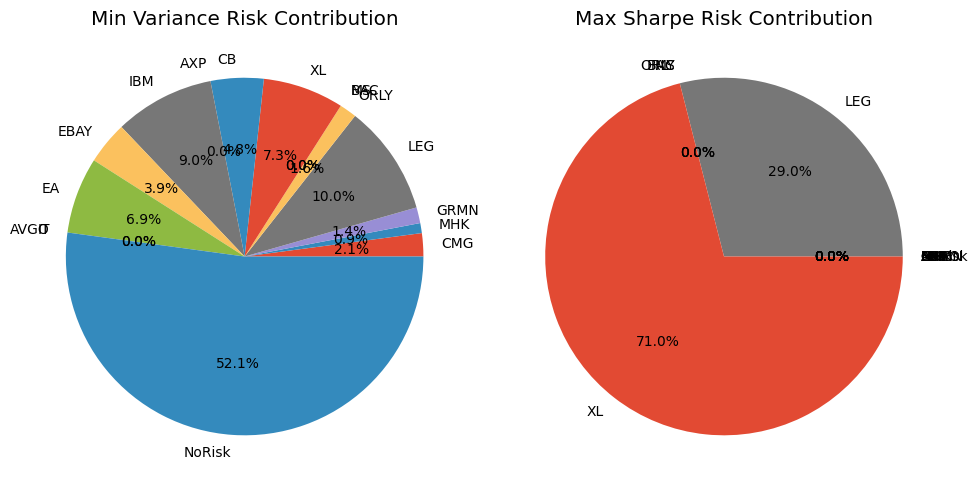

In [16]:
# === STEP 13: Diversification and Risk Contributions ===

# Entropy and Herfindahl Index
def entropy(weights):
    """Shannon entropy: higher → more diversified"""
    weights = np.array(weights)
    return -np.sum(weights * np.log(weights + 1e-10))  # avoid log(0)

def herfindahl(weights):
    """Herfindahl-Hirschman Index: lower → more diversified"""
    weights = np.array(weights)
    return np.sum(weights**2)

# Risk Contributions
def risk_contributions(weights, cov_matrix):
    """
    Computes the risk contribution of each asset to portfolio volatility.
    Returns: (individual contributions, total volatility)
    """
    weights = np.array(weights)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    mrc = (cov_matrix @ weights) / port_vol  # Marginal Risk Contribution
    rc = weights * mrc  # Total risk contribution per asset
    return rc, port_vol

# Compute metrics
ent_min_var = entropy(min_var_weights)
ent_max_sharpe = entropy(max_sharpe_weights)
herf_min_var = herfindahl(min_var_weights)
herf_max_sharpe = herfindahl(max_sharpe_weights)

print(f"\nDiversification Metrics:")
print(f" - Min Variance: Entropy = {ent_min_var:.4f}, Herfindahl = {herf_min_var:.4f}")
print(f" - Max Sharpe:   Entropy = {ent_max_sharpe:.4f}, Herfindahl = {herf_max_sharpe:.4f}")

# Compute risk contributions
rc_min_var, vol_min_var = risk_contributions(min_var_weights, cov_matrix)
rc_max_sharpe, vol_max_sharpe = risk_contributions(max_sharpe_weights, cov_matrix)

# Print contributions as %
print("\n--- Risk Contributions (as % of total volatility) ---")
print("Min Variance Portfolio:")
for sym, rc in zip(symbols, rc_min_var):
    if rc > 0.001:
        print(f"{sym}: {(rc / vol_min_var) * 100:.2f}%")

print("\nMax Sharpe Portfolio:")
for sym, rc in zip(symbols, rc_max_sharpe):
    if rc > 0.001:
        print(f"{sym}: {(rc / vol_max_sharpe) * 100:.2f}%")

# Plot pie charts
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.pie(rc_min_var, labels=symbols, autopct='%1.1f%%')
plt.title('Min Variance Risk Contribution')

plt.subplot(1, 2, 2)
plt.pie(rc_max_sharpe, labels=symbols, autopct='%1.1f%%')
plt.title('Max Sharpe Risk Contribution')

plt.tight_layout()
plt.show()



🟠 Save and Visualize Tangency Portfolio


--- Tangency Portfolio (True Max Sharpe) ---
Expected Return: 0.5343
Volatility:      0.5175
Sharpe Ratio:    1.0325
Weights (NoRisk included):
  LEG: 0.7198
  XL: 0.2554
  NoRisk: 0.0248


<Figure size 1000x600 with 0 Axes>

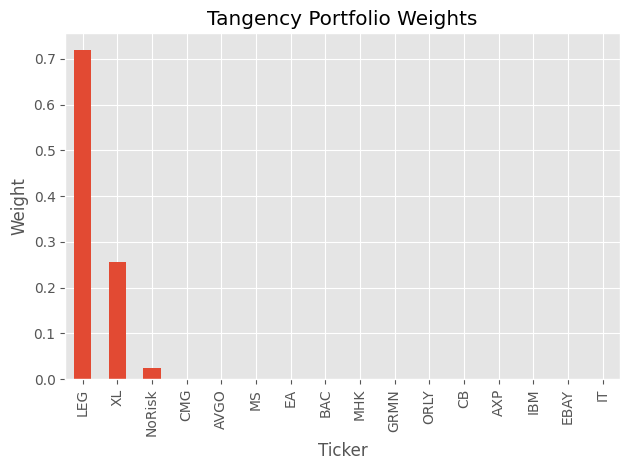

In [17]:
# === STEP 14: Save and Visualize Tangency Portfolio ===
# We export the tangency portfolio weights and visualize them with a bar chart.
# This portfolio is computed via direct Sharpe ratio maximization

# Create DataFrame for tangency portfolio
tangency_portfolio = pd.DataFrame({
    'Ticker': symbols,
    'Weight': tangent_weights
}).sort_values(by='Weight', ascending=False).reset_index(drop=True)

# Save to CSV
tangency_portfolio.to_csv("tangency_portfolio.csv", index=False)

# Display weights
print("\n--- Tangency Portfolio (True Max Sharpe) ---")
print(f"Expected Return: {tangent_return:.4f}")
print(f"Volatility:      {tangent_vol:.4f}")
print(f"Sharpe Ratio:    {tangent_sharpe:.4f}")
print("Weights (NoRisk included):")
for sym, w in zip(symbols, tangent_weights):
    if w > 0.001:
        print(f"  {sym}: {w:.4f}")

# Bar chart of weights
plt.figure(figsize=(10, 6))
tangency_portfolio.plot(kind='bar', x='Ticker', y='Weight', legend=False)
plt.title('Tangency Portfolio Weights')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

🧾 Final Notes & Next Steps (Markdown)

## Sector-Based Portfolio Optimization with Markowitz Theory

### Summary

In this notebook, we:
- Loaded sector-specific stock data and ensured equal sector representation
- Computed daily returns and optimized intra-sector portfolios using minimum variance
- Combined sector portfolios into a global one
- Added a real risk-free asset ('NoRisk') with constant price for training/validation/test
- Built and visualized the efficient frontier and the Capital Market Line (CML)
- Identified and analyzed the Min Variance, Max Sharpe, and Tangency Portfolios
- Evaluated out-of-sample performance over the last 6 months
- Analyzed diversification (Entropy, Herfindahl) and risk contributions
- Saved all portfolios to CSV and visualized weights

### Files Generated
- `final_portfolio.csv`
- `min_variance_portfolio.csv`
- `max_sharpe_portfolio.csv`
- `tangency_portfolio.csv`

---


### Note on Max Sharpe vs Tangency Portfolio

Although the Max Sharpe and Tangency portfolios often appear identical, they are derived differently:
- The Max Sharpe portfolio is selected from the efficient frontier grid as the one with the highest Sharpe ratio.
- The Tangency portfolio is computed directly via optimization of the Sharpe ratio objective.

Both represent the optimal risky portfolio, but small numerical differences may occur depending on grid resolution.


### Tangency vs Max Sharpe (Numerical Comparison)

Although the two portfolios are theoretically equivalent under standard assumptions,
small numerical differences can arise due to grid resolution or solver precision.

Below we compare the portfolio weights:


In [18]:
# Compute L1 and L2 norm difference between the two sets of weights
from numpy.linalg import norm

l1_diff = norm(max_sharpe_weights - tangent_weights, ord=1)
l2_diff = norm(max_sharpe_weights - tangent_weights)

print(f"\nDifference between Max Sharpe and Tangency weights:")
print(f"L1 norm: {l1_diff:.6f}")
print(f"L2 norm: {l2_diff:.6f}")


Difference between Max Sharpe and Tangency weights:
L1 norm: 0.049641
L2 norm: 0.031157


<Figure size 1000x400 with 0 Axes>

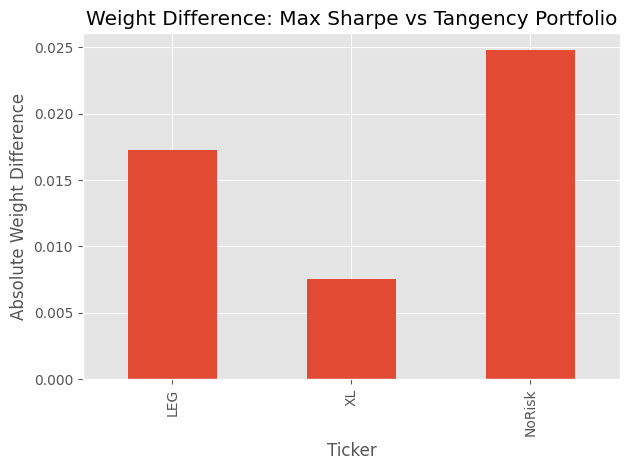

In [19]:
plt.figure(figsize=(10, 4))
weight_diff = pd.DataFrame({
    'Ticker': symbols,
    'Abs Difference': np.abs(max_sharpe_weights - tangent_weights)
})
weight_diff = weight_diff[weight_diff['Abs Difference'] > 0.001]
weight_diff.plot(x='Ticker', y='Abs Difference', kind='bar', legend=False)
plt.title('Weight Difference: Max Sharpe vs Tangency Portfolio')
plt.ylabel('Absolute Weight Difference')
plt.tight_layout()
plt.grid(True)
plt.show()

### Max Sharpe vs Tangency: Weight Differences

Below we compare the portfolio weights of the Max Sharpe (grid-based) and Tangency (optimization-based) portfolios.

Only assets with absolute differences > 0.001 are shown:

- Differences are minimal (< 2.5%) and mostly on small-weight assets
- This confirms that the efficient frontier was computed with adequate resolution
